# Climate indicator forecasts over Vanuatu using CMIP6 data

In this tutorial, we'll cover the following:
- How to select climate datasets from the CMIP6 archive
- Loading CMIP6 data stored in the Zarr format
- Calculate climate indices for extreme weather forecasts

In [ ]:
# !mamba uninstall -y odc-loader
# !mamba install -y cartopy obstore 'zarr>=3' 'python=3.11'

| 

In [2]:
import cartopy.crs as ccrs
import dask.diagnostics
import matplotlib.pyplot as plt
import obstore
import obstore.auth.planetary_computer
import pandas as pd
import planetary_computer
import pystac_client
import seaborn as sns
import tqdm
import xarray as xr
import xclim
import zarr

## Part 1: Getting cloud hosted CMIP6 data

The [Coupled Model Intercomparison Project Phase 6 (CMIP6)](https://en.wikipedia.org/wiki/CMIP6#CMIP_Phase_6)
dataset is a rich archive of modelling experiments carried out to predict the climate change impacts.
The datasets are stored using the [Zarr](https://zarr.dev) format, and we'll go over how to access it.

**Note**: This section was adapted from https://tutorial.xarray.dev/intermediate/remote_data/cmip6-cloud.html

Sources:
- https://esgf-node.llnl.gov/search/cmip6/
- CMIP6 data hosted on Google Cloud - https://console.cloud.google.com/marketplace/details/noaa-public/cmip6
- Pangeo/ESGF Cloud Data Access tutorial - https://pangeo-data.github.io/pangeo-cmip6-cloud/accessing_data.html

First, let's open a CSV containing the list of CMIP6 datasets available

In [3]:
df = pd.read_csv("https://cmip6.storage.googleapis.com/pangeo-cmip6.csv")
print(f"Number of rows: {len(df)}")
df.head()

Number of rows: 514818


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


Over 500,000 rows! Let's filter it down to the variable and experiment
we're interested in, e.g. daily max near-surface air temperature.

For the `variable_id`, you can look it up given some keyword at
https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y

For the `experiment_id`, download the spreadsheet from
https://github.com/ES-DOC/esdoc-docs/blob/master/cmip6/experiments/spreadsheet/experiments.xlsx,
go to the 'experiment' tab, and find the one you're interested in.

Another good place to find the right model runs is https://esgf-node.llnl.gov/search/cmip6
(once you get your head around the acronyms and short names).

Below, we'll filter to CMIP6 experiments matching:
- Daily Maximum Near-Surface Air Temperature [K] (variable_id: `tasmax`)
  - Alternatively, you can choose `pr` to get precipitation
- Shared Socioeconomic Pathway 3 (experiment_id: `ssp370`)
  - Alternatively, you can also try `ssp585` for the worst case scenario

In [4]:
df_tasmax = df.query("variable_id == 'tasmax' & experiment_id == 'ssp370'")
df_tasmax

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
13321,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,Amon,tasmax,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
20002,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp370,r1i1p1f1,day,tasmax,gr1,gs://cmip6/CMIP6/ScenarioMIP/NOAA-GFDL/GFDL-ES...,NaN,20180701
47029,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp370,r3i1p1f1,Amon,tasmax,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190119
47413,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp370,r2i1p1f1,Amon,tasmax,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190119
47490,ScenarioMIP,IPSL,IPSL-CM6A-LR,ssp370,r8i1p1f1,Amon,tasmax,gr,gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR...,NaN,20190119
...,...,...,...,...,...,...,...,...,...,...,...
501029,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp370,r107i1p1f1,day,tasmax,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20210101
501060,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp370,r108i1p1f1,day,tasmax,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20210101
501091,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp370,r109i1p1f1,day,tasmax,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20210101
504343,ScenarioMIP,EC-Earth-Consortium,EC-Earth3-AerChem,ssp370,r4i1p1f1,day,tasmax,gr,gs://cmip6/CMIP6/ScenarioMIP/EC-Earth-Consorti...,NaN,20210120


There's 376 modelled scenarios for SSP3.
Let's just get the URL to the last one in the list for now.

In [5]:
print(df_tasmax.zstore.iloc[-1])

gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ssp370/r1i1p1f1/day/tasmax/gn/v20210202/


## Part 2: Reading from the remote Zarr store

In many cases, you'll need to first connect to the cloud provider.
The CMIP6 dataset allows anonymous access, but for some cases,
you may need to authentication.

We'll connect to the CMIP6 Zarr store on Google Cloud using
[`zarr.storage.ObjectStore`](https://zarr.readthedocs.io/en/v3.1.0/user-guide/storage.html#object-store):

In [6]:
gcs_store = obstore.store.from_url(
    url="gs://cmip6/CMIP6/ScenarioMIP/CMCC/CMCC-ESM2/ssp370/r1i1p1f1/day/tasmax/gn/v20210202/",
    skip_signature=True,
)
store = zarr.storage.ObjectStore(store=gcs_store, read_only=True)

Once the Zarr store connection is in place, we can open it into an `xarray.Dataset` like so.

In [7]:
ds = xr.open_zarr(store=store, consolidated=True, zarr_format=2)
ds

/srv/conda/envs/notebook/lib/python3.11/site-packages/xarray_sentinel/esa_safe.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


<xarray.Dataset> Size: 7GB
Dimensions:    (time: 31390, lat: 192, lon: 288, bnds: 2)
Coordinates:
    height     float64 8B ...
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, bnds) float64 3kB dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, bnds) float64 5kB dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 251kB 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
    time_bnds  (time, bnds) object 502kB dask.array<chunksize=(15695, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tasmax     (time, lat, lon) float32 7GB dask.array<chunksize=(395, 192, 288), meta=np.ndarray>
Attributes: (12/51)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP AerChemMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0
    cmor_version:           3.6.0
    ...                     ...
    table_info:             Creation Date:(05 February 2020) MD5:6a248fd76c55...
    title:                  CMCC-ESM2 output prepared for CMIP6
    tracking_id:            hdl:21.14100/de484f2f-b950-4381-b33a-421f27482e6b
    variable_id:            tasmax
    variant_label:          r1i1p1f1
    version_id:             v20210202

### Selecting time slices

Let's say we want to calculate temperature changes between
2025 and 2050. We can access just the specific time points
needed using [`xr.Dataset.sel`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.sel.html).

In [8]:
tasmax_2025jan = ds.tasmax.sel(time="2025-01-16").squeeze()
tasmax_2050dec = ds.tasmax.sel(time="2050-12-16").squeeze()

Temperature change would just be 2050 minus 2025.

In [9]:
tasmax_change = tasmax_2050dec - tasmax_2025jan

Note that up to this point, we have not actually downloaded any
(big) data yet from the cloud. This is all working based on
metadata only.

To bring the data from the cloud to your local computer, call `.compute`.
This will take a while depending on your connection speed.

In [10]:
tasmax_change = tasmax_change.compute()

We can do a quick plot to show how maximum near-surface temperature
is predicted to change between 2025-2050 (from one modelled experiment).

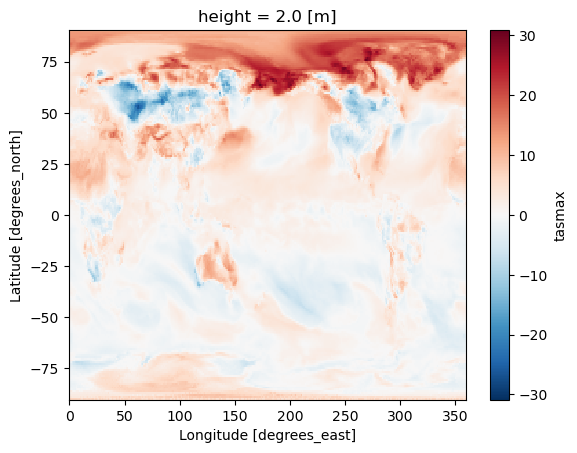

In [11]:
tasmax_change.plot.imshow()

This temperature change is for the entire planet. Let's zoom in over Vanuatu

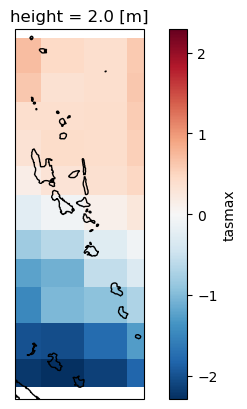

In [12]:
projection = ccrs.epsg(code=3832)  # PDC Mercator
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection))
tasmax_change.sel(lon=slice(166, 170), lat=slice(-22, -11)).plot.imshow(
    ax=ax, transform=ccrs.PlateCarree()
)
ax.set_extent(extents=[166, 170, -22, -11], crs=ccrs.PlateCarree())
ax.coastlines()

This CMIP6 output is very coarse, so there's only 4x11=44 pixels covering Vanuatu.
You could try to say that the northern regions is forecasted to experience
higher daily maximum temperatures than the South in 2050 compared to 2025,
but it's best to get more data before jumping to these conclusions.
Specifically:

- Look at an ensemble of forecasts from different CMIP6 models
- Potentially look at downscaled data that will show local patterns.

## Part 2b: Getting downscaled climate data

For a small country like Vanuatu that is ~400km wide by ~800km long,
it may be desirable to obtain higher spatial resolution projections.
The original CMIP6 datasets have a coarse spatial resolution of
1 arc degree or more (>100 km).

There are groups that have taken these CMIP6 datasets and processed them
using statistical downscaling + bias correction algorithms to produce
higher spatial resolution outputs of 0.25 arc degrees (~25km) or so.
Examples include:

- Climate Impact Lab's [Global Downscaled Projections for Climate Impacts Research](https://github.com/ClimateImpactLab/downscaleCMIP6)
- NASA Earth Exchange Global Daily Downscaled Projection ([NEX-GDDP-CMIP6](https://www.nccs.nasa.gov/services/data-collections/land-based-products/nex-gddp-cmip6))
- Carbonplan's CMIP6 downscaled products based on [4 different methods](https://carbonplan.org/research/cmip6-downscaling-explainer)

References:
- Gergel, D. R., Malevich, S. B., McCusker, K. E., Tenezakis, E., Delgado, M. T., Fish, M. A., and Kopp, R. E.: Global Downscaled Projections for Climate Impacts Research (GDPCIR): preserving quantile trends for modeling future climate impacts, Geosci. Model Dev., 17, 191–227, https://doi.org/10.5194/gmd-17-191-2024, 2024.
- Thrasher, B., Wang, W., Michaelis, A., Melton, F., Lee, T., & Nemani, R. (2022). NASA Global Daily Downscaled Projections, CMIP6. Scientific Data, 9(1), 262. https://doi.org/10.1038/s41597-022-01393-4

The examples below will use the
[CIL-GDPCIR-CC0](https://planetarycomputer.microsoft.com/dataset/cil-gdpcir-cc0)
dataset hosted on Planetary Computer

In [13]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/",
    modifier=planetary_computer.sign_inplace,
)

In [14]:
SSP_ID = "ssp585"  # "historical", "ssp126", "ssp245", "ssp370", "ssp585"
search = catalog.search(
    collections=["cil-gdpcir-cc0"],  # add "cil-gdpcir-cc-by" for more models
    query={"cmip6:experiment_id": {"eq": SSP_ID}},
)
ensemble = search.item_collection()
len(ensemble)

3

Let's look at precipitation (pr).

Code based on:
- https://planetarycomputer.microsoft.com/dataset/cil-gdpcir-cc0#Ensemble-example
- https://developmentseed.org/obstore/v0.7.1/examples/zarr/#example

In [15]:
# select this variable ID for all models in a collection
variable_id = "pr"  # or "tasmax"

datasets_by_model = []

for item in tqdm.tqdm(ensemble):
    asset = item.assets[variable_id]
    # print(asset.href, asset.extra_fields["xarray:open_kwargs"])

    credential_provider = (
        obstore.auth.planetary_computer.PlanetaryComputerCredentialProvider(
            url=asset.href, account_name="rhgeuwest"
        )
    )
    azure_store = obstore.store.from_url(
        url=asset.href, credential_provider=credential_provider
    )

    zarr_store = zarr.storage.ObjectStore(store=azure_store, read_only=True)
    datasets_by_model.append(xr.open_zarr(store=zarr_store, chunks={}))

all_datasets = xr.concat(
    datasets_by_model,
    dim=pd.Index([ds.attrs["source_id"] for ds in datasets_by_model], name="model"),
    combine_attrs="drop_conflicts",
)

100%|██████████| 3/3 [00:12<00:00,  4.12s/it]


In [16]:
all_datasets

<xarray.Dataset> Size: 781GB
Dimensions:  (model: 3, time: 31390, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float64 6kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 12kB -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time     (time) object 251kB 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
  * model    (model) object 24B 'INM-CM5-0' 'INM-CM4-8' 'FGOALS-g3'
Data variables:
    pr       (model, time, lat, lon) float64 781GB dask.array<chunksize=(1, 365, 360, 360), meta=np.ndarray>
Attributes: (12/30)
    Conventions:                  CF-1.7 CMIP-6.2
    activity_id:                  ScenarioMIP
    contact:                      climatesci@rhg.com
    dc6_bias_correction_method:   Quantile Delta Method (QDM)
    dc6_citation:                 Please refer to https://github.com/ClimateI...
    dc6_creation_date:            2022-02-04
    ...                           ...
    realm:                        atmos
    sub_experiment:               none
    sub_experiment_id:            none
    table_id:                     day
    variable_id:                  pr
    variant_label:                r1i1p1f1

We now have a data cube consisting of 3 models, spanning a time range from 2015 to 2100.
Let's subset the data over Vanuatu.

In [17]:
ds_vanuatu = all_datasets.sel(lon=slice(166, 170), lat=slice(-22, -11))
ds_vanuatu

<xarray.Dataset> Size: 531MB
Dimensions:  (model: 3, time: 31390, lat: 44, lon: 16)
Coordinates:
  * lat      (lat) float64 352B -21.88 -21.62 -21.38 ... -11.62 -11.38 -11.12
  * lon      (lon) float64 128B 166.1 166.4 166.6 166.9 ... 169.4 169.6 169.9
  * time     (time) object 251kB 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
  * model    (model) object 24B 'INM-CM5-0' 'INM-CM4-8' 'FGOALS-g3'
Data variables:
    pr       (model, time, lat, lon) float64 530MB dask.array<chunksize=(1, 365, 44, 16), meta=np.ndarray>
Attributes: (12/30)
    Conventions:                  CF-1.7 CMIP-6.2
    activity_id:                  ScenarioMIP
    contact:                      climatesci@rhg.com
    dc6_bias_correction_method:   Quantile Delta Method (QDM)
    dc6_citation:                 Please refer to https://github.com/ClimateI...
    dc6_creation_date:            2022-02-04
    ...                           ...
    realm:                        atmos
    sub_experiment:               none
    sub_experiment_id:            none
    table_id:                     day
    variable_id:                  pr
    variant_label:                r1i1p1f1

## Part 3: Compute climate indicators using `xclim`

The `xclim` library allows us to compute climate indicators based on
some statistic from raw climate values such as temperature or precipitation.

We'll learn how to calculate a 'drought' indicator in this section. Specifically,
compute [maximum consecutive dry days](https://xclim.readthedocs.io/en/stable/api_indicators.html#xclim.indicators.atmos.maximum_consecutive_dry_days)
with threshold of <1 mm/day.

In [18]:
da_cdd = xclim.indicators.atmos.maximum_consecutive_dry_days(
    ds=ds_vanuatu,
    thresh="1 mm/day",
)
da_cdd

/srv/conda/envs/notebook/lib/python3.11/site-packages/xclim/core/cfchecks.py:77: UserWarning: Variable does not have a `cell_methods` attribute.
  _check_cell_methods(getattr(vardata, "cell_methods", None), data["cell_methods"])
/srv/conda/envs/notebook/lib/python3.11/site-packages/xclim/core/cfchecks.py:79: UserWarning: Variable does not have a `standard_name` attribute.
  check_valid(vardata, "standard_name", data["standard_name"])


<xarray.DataArray 'cdd' (model: 3, time: 86, lat: 44, lon: 16)> Size: 727kB
dask.array<where, shape=(3, 86, 44, 16), dtype=float32, chunksize=(1, 1, 44, 16), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 352B -21.88 -21.62 -21.38 ... -11.62 -11.38 -11.12
  * lon      (lon) float64 128B 166.1 166.4 166.6 166.9 ... 169.4 169.6 169.9
  * model    (model) object 24B 'INM-CM5-0' 'INM-CM4-8' 'FGOALS-g3'
  * time     (time) object 688B 2015-01-01 00:00:00 ... 2100-01-01 00:00:00
Attributes:
    units:          days
    cell_methods:    time: sum over days
    history:        [2025-08-09 06:30:06] cdd: CDD(pr=pr, thresh='1 mm/day', ...
    standard_name:  number_of_days_with_lwe_thickness_of_precipitation_amount...
    long_name:      Maximum consecutive days with daily precipitation below 1...
    description:    Annual maximum number of consecutive days with daily prec...

We have 3 models, over 86 timesteps (2015-2100), across 44x16 pixels over Vanuatu.
Let's compute this 'drought' indicator for one model and one year only.

In [19]:
with dask.diagnostics.ProgressBar():
    vu_cdd = da_cdd.isel(model=0, time=-1).compute()

[########################################] | 100% Completed | 15.33 ss


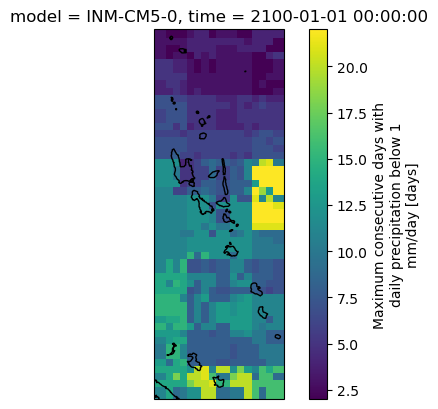

In [20]:
projection = ccrs.epsg(code=3832)  # PDC Mercator
fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection))
vu_cdd.sel(lon=slice(166, 170), lat=slice(-22, -11)).plot.imshow(
    ax=ax, transform=ccrs.PlateCarree()
)
ax.set_extent(extents=[166, 170, -22, -11], crs=ccrs.PlateCarree())
ax.coastlines()

Let's now compute this 'drought' indicator from 2025-2075,
over an ensemble of three models. This will take about 5min to compute.

In [21]:
with dask.diagnostics.ProgressBar():
    vu_cdd = da_cdd.sel(time=slice("2025", "2075")).compute()

[########################################] | 100% Completed | 303.63 s


Over the 44x16 pixels over Vanuatu, we'll get the maximum of all maximum
consecutive dry day (cdd) values, per model. The `.max` (highest) value is taken,
because we are interested in extreme values in terms of many dry days, but you
could also get the `.median` statistic or `.min` (lowest) statistic.

In [22]:
cdd_mean = vu_cdd.max(dim=("lat", "lon"))
cdd_mean

<xarray.DataArray 'cdd' (model: 3, time: 51)> Size: 612B
array([[27., 27., 27., 20., 29., 17., 22., 21., 26., 26., 27., 25., 20.,
        25., 22., 21., 22., 16., 27., 26., 22., 22., 29., 33., 23., 25.,
        21., 37., 35., 15., 16., 25., 35., 23., 18., 22., 16., 28., 29.,
        24., 21., 27., 22., 50., 31., 21., 23., 21., 19., 24., 22.],
       [26., 31., 30., 32., 26., 20., 19., 34., 37., 33., 38., 24., 22.,
        25., 27., 19., 32., 22., 34., 40., 19., 22., 24., 19., 20., 24.,
        20., 21., 22., 18., 21., 20., 17., 22., 17., 25., 25., 21., 22.,
        24., 20., 20., 26., 27., 19., 19., 24., 27., 29., 17., 24.],
       [21., 22., 18., 25., 30., 19., 30., 23., 25., 28., 22., 19., 23.,
        25., 26., 26., 19., 23., 26., 31., 20., 22., 21., 14., 25., 20.,
        25., 28., 20., 35., 33., 23., 28., 26., 20., 24., 23., 41., 33.,
        31., 26., 20., 20., 31., 23., 27., 23., 25., 24., 23., 20.]],
      dtype=float32)
Coordinates:
  * model    (model) object 24B 'INM-CM5-0' 'INM-CM4-8' 'FGOALS-g3'
  * time     (time) object 408B 2025-01-01 00:00:00 ... 2075-01-01 00:00:00

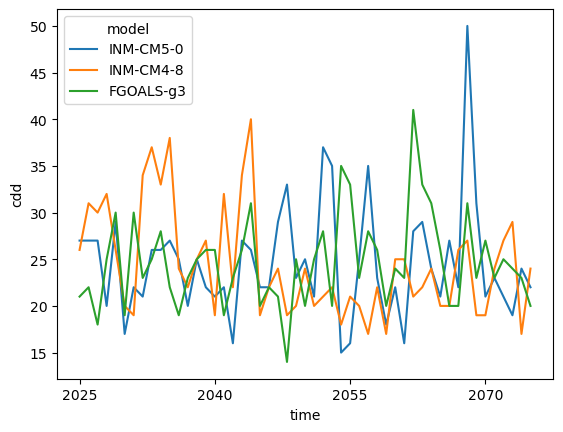

In [23]:
cdd_mean.plot.line(x="time")

There is a lot of variation in the 3 models over time, so let's plot the general mean
trend, with error bands. We will convert the data from an `xarray.Dataset` to a
`pandas.DataFrame` table before making this plot.

In [24]:
# Convert CFTime to Python datetime
if cdd_mean.time.dtype == "object":
    cdd_mean["time"] = cdd_mean.indexes["time"].to_datetimeindex(time_unit="s")

# Convert from xarray.Dataset to pandas.DataFrame
df_cdd = cdd_mean.to_pandas().T

# Save to csv file (optional)
df_cdd.to_csv(path_or_buf=f"vut_consecutive_dry_days_{SSP_ID}.csv")

df_cdd.head()

/tmp/ipykernel_2725/1597848363.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  cdd_mean["time"] = cdd_mean.indexes["time"].to_datetimeindex(time_unit="s")


model,INM-CM5-0,INM-CM4-8,FGOALS-g3
time,,,
2025-01-01,27.0,26.0,21.0
2026-01-01,27.0,31.0,22.0
2027-01-01,27.0,30.0,18.0
2028-01-01,20.0,32.0,25.0
2029-01-01,29.0,26.0,30.0


In [25]:
# Collapse or melt many columns (models) into one column
df_cdd2 = df_cdd.melt(ignore_index=False)
df_cdd2

,model,value
time,,
2025-01-01,INM-CM5-0,27.0
2026-01-01,INM-CM5-0,27.0
2027-01-01,INM-CM5-0,27.0
2028-01-01,INM-CM5-0,20.0
2029-01-01,INM-CM5-0,29.0
...,...,...
2071-01-01,FGOALS-g3,23.0
2072-01-01,FGOALS-g3,25.0
2073-01-01,FGOALS-g3,24.0


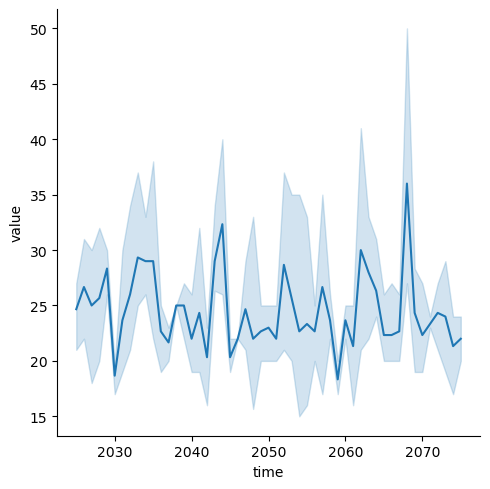

In [26]:
sns.relplot(data=df_cdd2, x="time", y="value", kind="line")

That's all! Hopefully this will get you started on how to handle CMIP6 climate data!